####Copyright 2021 DeepMind Technologies Limited. All Rights Reserved.

####Licensed under the Apache License, Version 2.0 (the "License");

####Full license text

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
# 
#     http://www.apache.org/licenses/LICENSE-2.0
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Epistemic neural network demo

Demo colab for ENN library.


## Imports

In [ ]:
!pip install -q dm-acme
!pip install -q dm-haiku==0.0.5
!pip install -q chex
!pip install -q optax
!pip install -q plotnine

     |████████████████████████████████| 314 kB 16.5 MB/s 
     |████████████████████████████████| 3.8 MB 40.1 MB/s 
     |████████████████████████████████| 287 kB 13.8 MB/s 
     |████████████████████████████████| 72 kB 430 kB/s 
     |████████████████████████████████| 140 kB 13.7 MB/s 


In [ ]:
#@title General imports

import warnings

warnings.filterwarnings('ignore')


#@title Development imports
from typing import Callable, NamedTuple

import numpy as np
import pandas as pd
import plotnine as gg

from acme.utils import loggers
from acme.utils.loggers.terminal import TerminalLogger
import dataclasses
import functools
import chex
import haiku as hk
import jax
import jax.numpy as jnp
import optax
import tensorflow as tf
import tensorflow_datasets as tfds

import abc
import typing_extensions
import dataclasses
from sklearn import datasets
from typing import Any, Callable, Dict, Iterator, NamedTuple, Optional, Tuple, Union, Sequence

## Base

https://github.com/deepmind/enn/blob/master/enn/base.py

In [ ]:
"""Base classes for Epistemic Neural Network design in JAX / Haiku."""

Array = Union[np.ndarray, jnp.DeviceArray]
DataIndex = Array  # Always integer elements
Index = Any  # Epistemic index, paired with network
RngKey = jnp.DeviceArray  # Integer pairs, see jax.random


class OutputWithPrior(NamedTuple):
  """Output wrapper for networks with prior functions."""
  train: Array
  prior: Array = np.zeros(1)
  extra: Dict[str, Array] = {}

  @property
  def preds(self) -> Array:
    return self.train + jax.lax.stop_gradient(self.prior)

Output = Union[Array, OutputWithPrior]

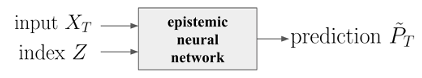

In [ ]:
class EpistemicModule(abc.ABC, hk.Module):
  """Epistemic neural network abstract base class as Haiku module."""

  @abc.abstractmethod
  def __call__(self, inputs: Array, index: Index) -> Output:
    """Forwards the epsitemic network y = f(x,z)."""

In [ ]:
class ApplyFn(typing_extensions.Protocol):
  """Applies the ENN at given parameters, inputs, index."""

  def __call__(self, params: hk.Params, inputs: Array, index: Index) -> Output:
    """Applies the ENN at given parameters, inputs, index."""

In [ ]:
class InitFn(typing_extensions.Protocol):
  """Initializes the ENN at given rng_key, inputs, index."""

  def __call__(self, rng_key: RngKey, inputs: Array, index: Index) -> hk.Params:
    """Initializes the ENN at given rng_key, inputs, index."""

In [ ]:
class EpistemicIndexer(typing_extensions.Protocol):
  """Generates indices for the ENN from random keys."""

  def __call__(self, key: RngKey) -> Index:
    """Samples a single index for the epistemic network."""

In [ ]:
@dataclasses.dataclass
class EpistemicNetwork:
  """Convenient pairing of Haiku transformed function and index sampler."""
  apply: ApplyFn
  init: InitFn
  indexer: EpistemicIndexer


In [ ]:
class Batch(NamedTuple):
  x: Array  # Inputs
  y: Array  # Targets
  data_index: Optional[DataIndex] = None  # Integer identifiers for data
  weights: Optional[Array] = None  # None should default to weights = jnp.ones
  extra: Dict[str, Array] = {}  # You can put other optional stuff here

BatchIterator = Iterator[Batch]  # Equivalent to the dataset we loop through
LossMetrics = Dict[str, Array]


class LossFn(typing_extensions.Protocol):
  """Calculates a loss based on one batch of data per rng_key."""

  def __call__(self,
               enn: EpistemicNetwork,
               params: hk.Params,
               batch: Batch,
               key: RngKey) -> Tuple[Array, LossMetrics]:
    """Computes a loss based on one batch of data and a random key."""


# Repeat EpistemicNetwork definition for networks with "state" e.g. BatchNorm
ApplyFnWithState = Callable[
    [hk.Params, hk.State, Array, Index], Tuple[Output, hk.State]]
InitFnWithState = Callable[[RngKey, Array, Index], Tuple[hk.Params, hk.State]]


@dataclasses.dataclass
class EpistemicNetworkWithState:
  """Convenient pairing of Haiku transformed function and index sampler."""
  apply: ApplyFnWithState
  init: InitFnWithState
  indexer: EpistemicIndexer


class LossFnWithState(typing_extensions.Protocol):
  """Calculates a loss based on one batch of data per rng_key."""

  def __call__(self,
               enn: EpistemicNetworkWithState,
               params: hk.Params,
               state: hk.State,
               batch: Batch,
               key: RngKey) -> Tuple[Array, Tuple[hk.State, LossMetrics]]:
    """Computes a loss based on one batch of data and a random key."""

https://github.com/deepmind/enn/blob/master/enn/supervised/base.py

In [ ]:
"""Base classes for a 'standard' supervised experiment."""

@dataclasses.dataclass
class BaseExperiment(abc.ABC):
  """Base interface for experiment classes."""
  dataset: BatchIterator

  @abc.abstractmethod
  def train(self, num_batches: int):
    """Train the ENN for num_batches."""

  @abc.abstractmethod
  def predict(
      self, inputs: Array, key: RngKey) -> Array:
    """Evaluate the trained model at given inputs."""

  @abc.abstractmethod
  def loss(self, batch: Batch, key: RngKey) -> Array:
    """Calculate the loss at a given batch."""

https://github.com/deepmind/enn/blob/master/enn/data_noise/base.py

In [ ]:
class DataNoise(typing_extensions.Protocol):

  def __call__(self, data: Batch, index: Index) -> Batch:
    """Apply some noise process to a batch of data based on epistemic index."""


def get_indexer(indexer: EpistemicIndexer):
  while hasattr(indexer, 'indexer'):
    indexer = indexer.indexer
  return indexer

## Utils

https://github.com/deepmind/enn/blob/master/enn/utils.py

In [ ]:
def make_batch_indexer(indexer: EpistemicIndexer,
                       batch_size: int) -> EpistemicIndexer:
  """Batches an EpistemicIndexer to produce batch_size index samples."""
  fold_in = jax.vmap(jax.random.fold_in, in_axes=[None, 0])
  batch_array = jnp.arange(batch_size)

  def batch_indexer(key: RngKey) -> Index:
    batch_keys = fold_in(key, batch_array)
    return jax.vmap(indexer)(batch_keys)

  return batch_indexer

def _clean_batch_data(data: Batch) -> Batch:
  """Checks some of the common shape/index issues for dummy data.."""
  # Make sure that the data has a separate batch dimension
  if data.y.ndim == 1:
    data = data._replace(y=data.y[:, None])

  # Data index to identify each instance
  if data.data_index is None:
    data = data._replace(data_index=np.arange(len(data.y))[:, None])

  # Weights to say how much each data.point is work
  if data.weights is None:
    data = data._replace(weights=np.ones(len(data.y))[:, None])
  return data

def make_batch_iterator(data: Batch,
                        batch_size: Optional[int] = None,
                        seed: int = 0) -> BatchIterator:
  """Converts toy-like training data to batch_iterator for sgd training."""
  data = _clean_batch_data(data)
  n_data = len(data.y)
  if not batch_size:
    batch_size = n_data

  ds = tf.data.Dataset.from_tensor_slices(data).cache()
  ds = ds.shuffle(min(n_data, 50 * batch_size), seed=seed)
  ds = ds.repeat().batch(batch_size)

  return iter(tfds.as_numpy(ds))

def parse_net_output(net_out: Output) -> Array:
  """Convert potential dict of network outputs to scalar prediction value."""
  if isinstance(net_out, OutputWithPrior):
    return net_out.preds
  else:
    return net_out

## Losses

In [ ]:
class SingleIndexLossFn(typing_extensions.Protocol):
  """Calculates a loss based on one batch of data per index.
  You can use utils.average_single_index_loss to make a LossFn out of the
  SingleIndexLossFn.
  """

  def __call__(self,
               apply: ApplyFn,
               params: hk.Params,
               batch: Batch,
               index: Index) -> Tuple[Array, LossMetrics]:
    """Computes a loss based on one batch of data and one index."""


def average_single_index_loss(single_loss: SingleIndexLossFn,
                              num_index_samples: int = 1) -> LossFn:
  """Average a single index loss over multiple index samples.
  Args:
    single_loss: loss function applied per epistemic index.
    num_index_samples: number of index samples to average.
  Returns:
    LossFn that comprises the mean of both the loss and the metrics.
  """

  def loss_fn(enn: EpistemicNetwork,
              params: hk.Params,
              batch: Batch,
              key: RngKey) -> Tuple[Array, LossMetrics]:
    batched_indexer = make_batch_indexer(enn.indexer, num_index_samples)
    batched_loss = jax.vmap(single_loss, in_axes=[None, None, None, 0])
    loss, metrics = batched_loss(enn.apply, params, batch, batched_indexer(key))
    return jnp.mean(loss), jax.tree_map(jnp.mean, metrics)
  return loss_fn


def add_data_noise(single_loss: SingleIndexLossFn,
                   noise_fn: DataNoise) -> SingleIndexLossFn:
  """Applies a DataNoise function to each batch of data."""

  def noisy_loss(apply: ApplyFn,
                 params: hk.Params,
                 batch: Batch,
                 index: Index) -> Tuple[Array, LossMetrics]:
    noisy_batch = noise_fn(batch, index)
    return single_loss(apply, params, noisy_batch, index)
  return noisy_loss


@dataclasses.dataclass
class L2Loss(SingleIndexLossFn):
  """L2 regression applied to a single epistemic index."""

  def __call__(self,
               apply: ApplyFn,
               params: hk.Params,
               batch: Batch,
               index: Index) -> Tuple[Array, LossMetrics]:
    """L2 regression applied to a single epistemic index."""
    chex.assert_shape(batch.y, (None, 1))
    chex.assert_shape(batch.data_index, (None, 1))
    net_out = parse_net_output(apply(params, batch.x, index))
    chex.assert_equal_shape([net_out, batch.y])
    sq_loss = jnp.square(parse_net_output(net_out) - batch.y)
    if batch.weights is None:
      batch_weights = jnp.ones_like(batch.data_index)
    else:
      batch_weights = batch.weights
    chex.assert_equal_shape([batch_weights, sq_loss])
    return jnp.mean(batch_weights * sq_loss), {}


@dataclasses.dataclass
class XentLoss(SingleIndexLossFn):
  """Cross-entropy classification single index loss."""
  num_classes: int

  def __post_init__(self):
    chex.assert_scalar_non_negative(self.num_classes - 2.0)

  def __call__(self,
               apply: ApplyFn,
               params: hk.Params,
               batch: Batch,
               index: Index) -> Tuple[Array, LossMetrics]:
    chex.assert_shape(batch.y, (None, 1))
    chex.assert_shape(batch.data_index, (None, 1))
    net_out = apply(params, batch.x, index)
    logits = parse_net_output(net_out)
    labels = jax.nn.one_hot(batch.y[:, 0], self.num_classes)

    softmax_xent = -jnp.sum(
        labels * jax.nn.log_softmax(logits), axis=1, keepdims=True)
    if batch.weights is None:
      batch_weights = jnp.ones_like(batch.data_index)
    else:
      batch_weights = batch.weights
    chex.assert_equal_shape([batch_weights, softmax_xent])
    return jnp.mean(batch_weights * softmax_xent), {}

## Experiment

https://github.com/deepmind/enn/blob/master/enn/supervised/sgd_experiment.py

In [ ]:
class TrainingState(NamedTuple):
  params: hk.Params
  opt_state: optax.OptState

class Experiment(BaseExperiment):
  """Class to handle supervised training.
  Optional eval_datasets which is a collection of datasets to *evaluate*
  the loss on every eval_log_freq steps.
  """

  def __init__(self,
               enn: EpistemicNetwork,
               loss_fn: LossFn,
               optimizer: optax.GradientTransformation,
               dataset: BatchIterator,
               seed: int = 0,
               logger: Optional[loggers.Logger] = None,
               train_log_freq: int = 1,
               eval_datasets: Optional[Dict[str, BatchIterator]] = None,
               eval_log_freq: int = 1):
    self.enn = enn
    self.dataset = dataset
    self.rng = hk.PRNGSequence(seed)

    # Internalize the loss_fn
    self._loss = jax.jit(functools.partial(loss_fn, self.enn))

    # Internalize the eval datasets
    self._eval_datasets = eval_datasets
    self._eval_log_freq = eval_log_freq

    # Forward network at random index
    def forward(
        params: hk.Params, inputs: Array, key: RngKey) -> Array:
      index = self.enn.indexer(key)
      return self.enn.apply(params, inputs, index)
    self._forward = jax.jit(forward)

    # Define the SGD step on the loss
    def sgd_step(
        state: TrainingState,
        batch: Batch,
        key: RngKey,
    ) -> Tuple[TrainingState, LossMetrics]:
      # Calculate the loss, metrics and gradients
      (loss, metrics), grads = jax.value_and_grad(self._loss, has_aux=True)(
          state.params, batch, key)
      metrics.update({'loss': loss})
      updates, new_opt_state = optimizer.update(grads, state.opt_state)
      new_params = optax.apply_updates(state.params, updates)
      new_state = TrainingState(
          params=new_params,
          opt_state=new_opt_state,
      )
      return new_state, metrics
    self._sgd_step = jax.jit(sgd_step)

    # Initialize networks
    batch = next(self.dataset)
    index = self.enn.indexer(next(self.rng))
    params = self.enn.init(next(self.rng), batch.x, index)
    opt_state = optimizer.init(params)
    self.state = TrainingState(params, opt_state)
    self.step = 0
    self.logger = logger or loggers.make_default_logger(
        'experiment', time_delta=0)
    self._train_log_freq = train_log_freq

  def train(self, num_batches: int):
    """Train the ENN for num_batches."""
    for _ in range(num_batches):
      self.step += 1
      self.state, loss_metrics = self._sgd_step(
          self.state, next(self.dataset), next(self.rng))

      # Periodically log this performance as dataset=train.
      if self.step % self._train_log_freq == 0:
        loss_metrics.update(
            {'dataset': 'train', 'step': self.step, 'sgd': True})
        self.logger.write(loss_metrics)

      # Periodically evaluate the other datasets.
      if self._eval_datasets and self.step % self._eval_log_freq == 0:
        for name, dataset in self._eval_datasets.items():
          loss, metrics = self._loss(
              self.state.params, next(dataset), next(self.rng))
          metrics.update({
              'dataset': name,
              'step': self.step,
              'sgd': False,
              'loss': loss,
          })
          self.logger.write(metrics)

  def predict(self, inputs: Array, key: RngKey) -> Array:
    """Evaluate the trained model at given inputs."""
    return self._forward(self.state.params, inputs, key)

  def loss(self, batch: Batch, key: RngKey) -> Array:
    """Evaluate the loss for one batch of data."""
    return self._loss(self.state.params, batch, key)

## Parameters set using dataclass

In [ ]:
@dataclasses.dataclass
class Config:
  num_batch: int = 1_000
  index_dim: int = 10
  num_index_samples: int = 10
  seed: int = 0
  prior_scale: float = 5.
  learning_rate: float = 1e-3
  noise_std: float = 0.1

FLAGS = Config()

## Regression problem with 1D output



### Problem Definition

https://github.com/deepmind/enn/blob/master/enn/supervised/regression_data.py

In [ ]:
"""Functions for 1D regression data."""

def make_regression_df() -> pd.DataFrame:
  """Creates our regression dataset."""
  seed = 0
  n_data = 10
  x = np.concatenate([np.linspace(0, 0.5, n_data), np.linspace(1, 1.5, n_data)])
  w = np.random.RandomState(seed).randn(n_data * 2) * 0.1
  # y = x + sin(3x) + sin(12x) + noise
  y = x + np.sin(3 * x) + np.sin(12 * x) + w
  return pd.DataFrame({'x': x, 'y': y}).reset_index()


def make_dataset(extra_input_dim: int = 1) -> BatchIterator:
  """Factory method to produce an iterator of Batches."""
  df = make_regression_df()
  data = Batch(
      x=np.vstack([df['x'].values, np.ones((extra_input_dim, len(df)))]).T,
      y=df['y'].values[:, None],
  )
  chex.assert_shape(data.x, (None, 1 + extra_input_dim))
  return make_batch_iterator(data)


def make_plot(experiment: BaseExperiment,
              num_sample: int = 20,
              extra_input_dim: int = 1) -> gg.ggplot:
  """Generate a regression plot with sampled predictions."""
  plot_df = make_plot_data(
      experiment, num_sample=num_sample, extra_input_dim=extra_input_dim)

  p = (gg.ggplot()
       + gg.aes('x', 'y')
       + gg.geom_point(data=make_regression_df(), size=3, colour='blue')
       + gg.geom_line(gg.aes(group='k'), data=plot_df, alpha=0.5)
      )

  return p


def make_plot_data(experiment: BaseExperiment,
                   num_sample: int = 20,
                   extra_input_dim: int = 1) -> pd.DataFrame:
  """Generate a panda dataframe with sampled predictions."""
  preds_x = np.vstack([np.linspace(-1, 2), np.ones((extra_input_dim, 50))]).T

  data = []
  rng = hk.PRNGSequence(jax.random.PRNGKey(seed=0))
  for k in range(num_sample):
    net_out = experiment.predict(preds_x, key=next(rng))
    preds_y = parse_net_output(net_out)
    data.append(pd.DataFrame({'x': preds_x[:, 0], 'y': preds_y[:, 0], 'k': k}))
  plot_df = pd.concat(data)

  return plot_df

### Model Definition

https://github.com/deepmind/enn/blob/master/enn/networks/priors.py

In [ ]:
PriorFn = Callable[[Array, Index], Array]

In [ ]:
class EnnWithAdditivePrior(EpistemicNetwork):
  """Create an ENN with additive prior_fn applied to outputs."""

  def __init__(self,
               enn: EpistemicNetwork,
               prior_fn: PriorFn,
               prior_scale: float = 1.):
    """Create an ENN with additive prior_fn applied to outputs."""
    def apply_fn(params: hk.Params,
                 inputs: Array,
                 index: Index) -> OutputWithPrior:
      net_out = enn.apply(params, inputs, index)
      prior = prior_scale * prior_fn(inputs, index)
      if isinstance(net_out, OutputWithPrior):
        net_out: OutputWithPrior = net_out
        return net_out._replace(prior=net_out.prior + prior)
      else:
        return OutputWithPrior(train=net_out, prior=prior)
    super().__init__(
        apply=apply_fn,
        init=enn.init,
        indexer=enn.indexer,
    )

https://github.com/deepmind/enn/blob/master/enn/networks/indexers.py

In [ ]:
class PrngIndexer(EpistemicIndexer):
  """Index by JAX PRNG sequence."""

  def __call__(self, key: RngKey) -> Index:
    return key


@dataclasses.dataclass
class EnsembleIndexer(EpistemicIndexer):
  """Index into an ensemble by integer."""
  num_ensemble: int

  def __call__(self, key: RngKey) -> Index:
    return jax.random.randint(key, [], 0, self.num_ensemble)


@dataclasses.dataclass
class GaussianIndexer(EpistemicIndexer):
  """A Gaussian indexer ~ N(0, I)."""
  index_dim: int

  def __call__(self, key: RngKey) -> Index:
    return jax.random.normal(key, shape=[self.index_dim])


@dataclasses.dataclass
class ScaledGaussianIndexer(EpistemicIndexer):
  """A scaled Gaussian indexer."""
  index_dim: int
  # When index_scale is 1.0 the returned random variable has expected norm = 1.
  index_scale: float = 1.0

  def __call__(self, key: RngKey) -> Index:
    return self.index_scale / jnp.sqrt(self.index_dim) * jax.random.normal(
        key, shape=[self.index_dim])


@dataclasses.dataclass
class GaussianWithUnitIndexer(EpistemicIndexer):
  """Produces index (1, z) for z dimension=index_dim-1 unit ball."""
  index_dim: int

  @property
  def mean_index(self) -> Array:
    return jnp.append(1, jnp.zeros(self.index_dim - 1))

  def __call__(self, key: RngKey) -> Index:
    return jnp.append(1, jax.random.normal(
        key, shape=[self.index_dim - 1]) / jnp.sqrt(self.index_dim - 1))


@dataclasses.dataclass
class DirichletIndexer(EpistemicIndexer):
  """Samples a Dirichlet index with parameter alpha."""
  alpha: Array

  def __call__(self, key: RngKey) -> Index:
    return jax.random.dirichlet(key, self.alpha)

https://github.com/deepmind/enn/blob/master/enn/networks/ensembles.py

In [ ]:
"""Implementing some types of ENN ensembles in JAX."""

class Ensemble(EpistemicNetwork):
  """Ensemble ENN that uses a dot product in param space.
  Repeats parameters by an additional *ensemble* dimension in axis=0.
  Applying the parameters selects one single component of parameters per index.
  """

  def __init__(self,
               model: hk.Transformed,
               num_ensemble: int):
    self.model = model
    self.num_ensemble = num_ensemble

    def init(key: chex.PRNGKey, inputs: chex.Array, index: int) -> hk.Params:
      del index  # Unused
      batched_init = jax.vmap(model.init, in_axes=[0, None], out_axes=0)
      return batched_init(jax.random.split(key, num_ensemble), inputs)

    def apply(params: hk.Params, inputs: chex.Array, index: int) -> Output:
      one_hot_index = jax.nn.one_hot(index, num_ensemble)
      param_selector = lambda p: jnp.einsum('i...,i->...', p, one_hot_index)
      sub_params = jax.tree_map(param_selector, params)
      return model.apply(sub_params, inputs)

    indexer = EnsembleIndexer(num_ensemble)
    super().__init__(apply, init, indexer)


def make_mlp_ensemble_prior_fns(
    output_sizes: Sequence[int],
    dummy_input: Array,
    num_ensemble: int,
    seed: int = 0,
    w_init: Optional[hk.initializers.Initializer] = None,
    b_init: Optional[hk.initializers.Initializer] = None
) -> Sequence[Callable[[Array], Array]]:
  """Factory method for creating ensemble of prior functions."""
  rng = hk.PRNGSequence(seed)
  def net_fn(x):
    layers = [
        hk.Flatten(),
        hk.nets.MLP(output_sizes, w_init=w_init, b_init=b_init)
    ]
    return hk.Sequential(layers)(x)

  transformed = hk.without_apply_rng(hk.transform(net_fn))

  prior_fns = []
  for _ in range(num_ensemble):
    params = transformed.init(next(rng), dummy_input)
    prior_fns.append(lambda x, params=params: transformed.apply(params, x))
  return prior_fns


def combine_functions_choice_via_index(
    prior_fns: Sequence[Callable[[Array], Array]],
) -> PriorFn:
  """Combines functions to a PriorFn(x, z), selecting fn by ensemble index."""
  return lambda x, z: jax.lax.switch(z, prior_fns, x)

  
class MLPEnsembleMatchedPrior(EpistemicNetwork):
  """Ensemble of MLPs with matched prior functions."""

  def __init__(
      self,
      output_sizes: Sequence[int],
      dummy_input: Array,
      num_ensemble: int,
      prior_scale: float = 1.,
      seed: int = 0,
      w_init: Optional[hk.initializers.Initializer] = None,
      b_init: Optional[hk.initializers.Initializer] = None
  ):
    """Ensemble of MLPs with matched prior functions."""
    mlp_priors = make_mlp_ensemble_prior_fns(
        output_sizes, dummy_input, num_ensemble, seed)

    def net_fn(x: Array) -> Array:
      x = hk.Flatten()(x)
      return hk.nets.MLP(output_sizes, w_init, b_init)(x)
    transformed = hk.without_apply_rng(hk.transform(net_fn))

    ensemble = Ensemble(transformed, num_ensemble)
    enn = EnnWithAdditivePrior(
        enn=ensemble,
        prior_fn=combine_functions_choice_via_index(mlp_priors),
        prior_scale=prior_scale,
    )
    super().__init__(enn.apply, enn.init, enn.indexer)

### Noise

https://github.com/deepmind/enn/blob/master/enn/networks/indexers.py

In [ ]:
class DataNoise(typing_extensions.Protocol):

  def __call__(self, data: Batch, index: Index) -> Batch:
    """Apply some noise process to a batch of data based on epistemic index."""


def get_indexer(indexer: EpistemicIndexer):
  while hasattr(indexer, 'indexer'):
    indexer = indexer.indexer
  return indexer

https://github.com/deepmind/enn/blob/master/enn/data_noise/gaussian.py

In [ ]:
NoiseFn = Callable[[DataIndex, Index], Array]


def make_noise_fn(enn: EpistemicNetwork,
                  noise_std: float,
                  seed: int = 0) -> NoiseFn:
  """Factory method to create noise_fn for given ENN."""
  indexer = get_indexer(enn.indexer)

  if isinstance(indexer, EnsembleIndexer):
    return _make_ensemble_gaussian_noise(noise_std, seed)

  elif isinstance(indexer, GaussianIndexer):
    return _make_gaussian_index_noise(indexer.index_dim, noise_std, seed)

  elif isinstance(indexer, ScaledGaussianIndexer):
    return _make_scaled_gaussian_index_noise(indexer.index_dim, noise_std, seed)

  elif isinstance(indexer, GaussianWithUnitIndexer):
    # Ignore the first component which is always 1 and not Gaussian.
    effective_index_dim = indexer.index_dim - 1
    raw_noise = _make_scaled_gaussian_index_noise(
        effective_index_dim, noise_std, seed)
    noise_fn = lambda d, z: raw_noise(d, z[1:])  # Don't include unit component.
    return noise_fn

  else:
    raise ValueError(f'Unsupported ENN={enn}.')

def _make_key(data_index: Array, seed: int) -> RngKey:
  """Creates RngKeys for a batch of data index."""
  chex.assert_shape(data_index, (None, 1))
  return jax.vmap(jax.random.PRNGKey)(jnp.squeeze(data_index, axis=1) + seed)


def _make_ensemble_gaussian_noise(noise_std: float, seed: int) -> NoiseFn:
  """Factory method to add Gaussian noise for ensemble index."""
  batch_fold_in = jax.vmap(jax.random.fold_in)
  batch_normal = jax.vmap(jax.random.normal)

  def noise_fn(data_index: DataIndex, index: Index) -> Array:
    """Assumes integer index for ensemble."""
    chex.assert_shape(data_index, (None, 1))
    if not index.shape:  # If it's a single integer -> repeat for batch
      index = jnp.repeat(index, len(data_index))
    data_keys = _make_key(data_index, seed)
    batch_keys = batch_fold_in(data_keys, index)
    samples = batch_normal(batch_keys)[:, None]
    chex.assert_equal_shape([samples, data_index])
    return samples * noise_std

  return noise_fn


def _make_scaled_gaussian_index_noise(
    index_dim: int,
    noise_std: float,
    seed: int) -> NoiseFn:
  """Factory method to add Gaussian noise for index MLP."""
  std_gauss = lambda x: jax.random.normal(x, [index_dim])
  sample_std_gaussian = jax.vmap(std_gauss)

  def noise_fn(data_index: DataIndex, index: Index) -> Array:
    """Assumes scaled Gaussian index with reserved first component."""
    chex.assert_shape(data_index, (None, 1))
    b_keys = _make_key(data_index, seed)
    b = sample_std_gaussian(b_keys)

    # Expanding the index to match the batch
    batch_size = data_index.shape[0]
    z = jnp.repeat(jnp.expand_dims(index, 0), batch_size, axis=0)
    chex.assert_shape(z, [batch_size, index_dim])
    noise = jnp.sum(b * z, axis=1, keepdims=True) * noise_std
    chex.assert_equal_shape([noise, data_index])
    return noise

  return noise_fn


def _make_gaussian_index_noise(
    index_dim: int,
    noise_std: float,
    seed: int,
) -> NoiseFn:
  """Factory method for Gaussian indexer."""
  def sample_sphere(key: chex.PRNGKey) -> chex.Array:
    x = jax.random.normal(key, shape=[index_dim])
    return x / jnp.sqrt(jnp.sum(x ** 2))
  batch_sample_sphere = jax.vmap(sample_sphere)

  def noise_fn(data_index: DataIndex, index: Index) -> Array:
    """Assumes scaled Gaussian index with reserved first component."""
    chex.assert_shape(data_index, (None, 1))
    b_keys = _make_key(data_index, seed)
    b = batch_sample_sphere(b_keys)

    # Expanding the index to match the batch
    batch_size = data_index.shape[0]
    z = jnp.repeat(jnp.expand_dims(index, 0), batch_size, axis=0)
    chex.assert_shape(z, [batch_size, index_dim])
    noise = jnp.sum(b * z, axis=1, keepdims=True) * noise_std
    chex.assert_equal_shape([noise, data_index])
    return noise

  return noise_fn


@dataclasses.dataclass
class GaussianTargetNoise(DataNoise):
  """Apply Gaussian noise to the target y."""
  enn: EpistemicNetwork
  noise_std: float
  seed: int = 0

  def __call__(self, data: Batch, index: Index) -> Batch:
    """Apply Gaussian noise to the target y."""
    chex.assert_shape(data.y, (None, 1))  # Only implemented for 1D now.
    noise_fn = make_noise_fn(self.enn, self.noise_std, self.seed)
    y_noise = noise_fn(data.data_index, index)
    return data._replace(y=data.y + y_noise)

In [ ]:
#@title Create the regression experiment

# Generate dataset
dataset = make_dataset()

# Logger
logger = TerminalLogger('supervised_regression')

# Create Ensemble ENN with a prior network 
enn = MLPEnsembleMatchedPrior(
    output_sizes=[50, 50, 1],
    dummy_input=next(dataset).x,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,)

# L2 loss on perturbed outputs 
noise_fn = GaussianTargetNoise(enn, FLAGS.noise_std, FLAGS.seed)
single_loss = add_data_noise(L2Loss(), noise_fn)
loss_fn = average_single_index_loss(single_loss, FLAGS.num_index_samples)
 
# Optimizer
optimizer = optax.adam(FLAGS.learning_rate)

# Aggregating different components of the experiment
experiment = Experiment(
    enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [ ]:
# Train the experiment
experiment.train(FLAGS.num_batch)

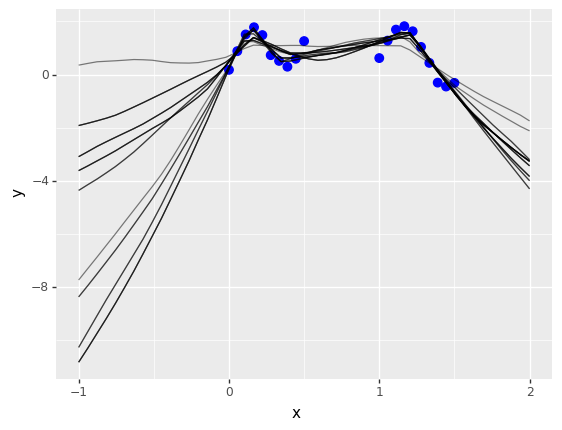

In [ ]:
#@title Plot the output
p = make_plot(experiment)
_ = p.draw()

## Classification problem with 2 labels



### Problem Definition

https://github.com/deepmind/enn/blob/master/enn/supervised/classification_data.py

In [ ]:
"""Functions for 2D classification."""

def make_dataset(num_sample: int = 10,
                 prob_swap: float = 0.,
                 seed: int = 0) -> BatchIterator:
  """Make a 2 moons dataset with num_sample per class and prob_swap label."""
  x, y = datasets.make_moons(2 * num_sample, noise=0.1, random_state=seed)

  # Swap the labels for data with prob_swap
  swaps = np.random.RandomState(seed).binomial(1, prob_swap, len(y))
  swap_locs = np.where(swaps)[0]
  y[swap_locs] = 1 - y[swap_locs]

  return make_batch_iterator(Batch(x, y))


def make_dataframe(
    dataset: Optional[BatchIterator] = None) -> pd.DataFrame:
  dataset = dataset or make_dataset()
  batch = next(dataset)
  vals = np.hstack([batch.x, batch.y])
  return pd.DataFrame(vals, columns=['x1', 'x2', 'label'])


def gen_2d_grid(plot_range: float) -> np.ndarray:
  """Generates a 2D grid for data in a certain_range."""
  data = []
  x_range = np.linspace(-plot_range, plot_range)
  for x1 in x_range:
    for x2 in x_range:
      data.append((x1, x2))
  return np.vstack(data)


def make_plot_data(experiment: BaseExperiment,
                   num_sample: int) -> pd.DataFrame:
  """Generate a classification plot with sampled predictions."""
  preds_x = gen_2d_grid(plot_range=3)

  data = []
  rng = hk.PRNGSequence(jax.random.PRNGKey(seed=0))
  for k in range(num_sample):
    net_out = experiment.predict(preds_x, key=next(rng))
    logits = parse_net_output(net_out)
    preds_y = jax.nn.softmax(logits)
    data.append(pd.DataFrame({
        'x1': preds_x[:, 0], 'x2': preds_x[:, 1], 'label': preds_y[:, 1],
        'sample': k
    }))
  return pd.concat(data)


def make_sample_plot(plot_df: pd.DataFrame,
                     data_df: Optional[pd.DataFrame] = None):
  """Make a plot of 2D classification samples over dataset."""
  if data_df is None:
    data_df = make_dataframe()
  p = (gg.ggplot()
       + gg.aes('x1', 'x2', fill='label')
       + gg.geom_tile(data=plot_df, alpha=0.75)
       + gg.scale_fill_continuous(limits=[0, 1])
       + gg.geom_point(data=data_df,
                       colour='black', size=5, stroke=2)
       + gg.facet_wrap('sample', labeller='label_both')
       + gg.ggtitle('Posterior samples from ENN')
       + gg.theme(figure_size=(20, 14), panel_spacing=0.2))
  return p


def make_mean_plot(plot_df: pd.DataFrame,
                   data_df: Optional[pd.DataFrame] = None):
  """Make a plot of 2D classification of the mean of the samples."""
  mean_df = plot_df.groupby(['x1', 'x2'])['label'].mean().reset_index()
  if data_df is None:
    data_df = make_dataframe()
  p = (gg.ggplot()
       + gg.aes('x1', 'x2', fill='label')
       + gg.geom_tile(data=mean_df, alpha=0.75)
       + gg.scale_fill_continuous(limits=[0, 1])
       + gg.geom_point(data=data_df,
                       colour='black', size=5, stroke=2)
       + gg.ggtitle('Posterior mean from ENN')
       + gg.theme(figure_size=(12, 10), panel_spacing=0.2))
  return p


def make_mean_plot_data(
    experiment: BaseExperiment) -> Tuple[pd.DataFrame, pd.DataFrame]:
  plot_df = make_plot_data(experiment, num_sample=100)
  dataframe = make_dataframe(experiment.dataset)
  mean_df = plot_df.groupby(['x1', 'x2'])['label'].mean().reset_index()

  return mean_df, dataframe


def colab_plots(experiment: BaseExperiment):
  plot_df = make_plot_data(experiment, num_sample=100)
  dataframe = make_dataframe(experiment.dataset)
  make_mean_plot(plot_df, dataframe).draw()
  make_sample_plot(plot_df[plot_df['sample'] < 12],
                   dataframe).draw()

In [ ]:
#@title Create the classification experiment

# Generate dataset
dataset = make_dataset()
num_classes = 2

# Logger
logger = TerminalLogger('supervised_regression')

# Create Ensemble ENN with a prior network
enn = MLPEnsembleMatchedPrior(
    output_sizes=[50, 50, num_classes],
    dummy_input=next(dataset).x,
    num_ensemble=FLAGS.index_dim,
    prior_scale=FLAGS.prior_scale,
    seed=FLAGS.seed,
)

# Cross entropy loss
loss_fn = average_single_index_loss(
    single_loss= XentLoss(num_classes),
    num_index_samples=FLAGS.num_index_samples
)

# Optimizer
optimizer = optax.adam(FLAGS.learning_rate)

# Aggregating different components of the experiment
experiment = Experiment(
    enn, loss_fn, optimizer, dataset, FLAGS.seed, logger=logger)

In [ ]:
# Train the experiment
experiment.train(FLAGS.num_batch)

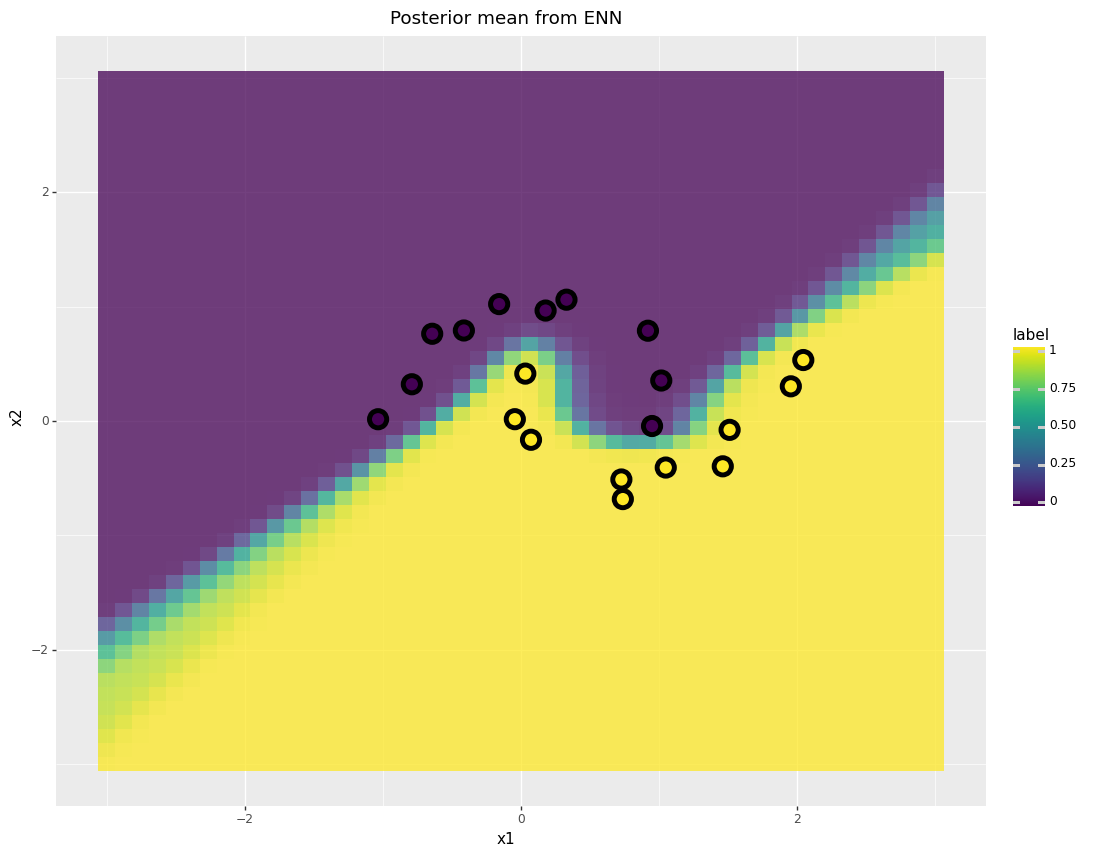

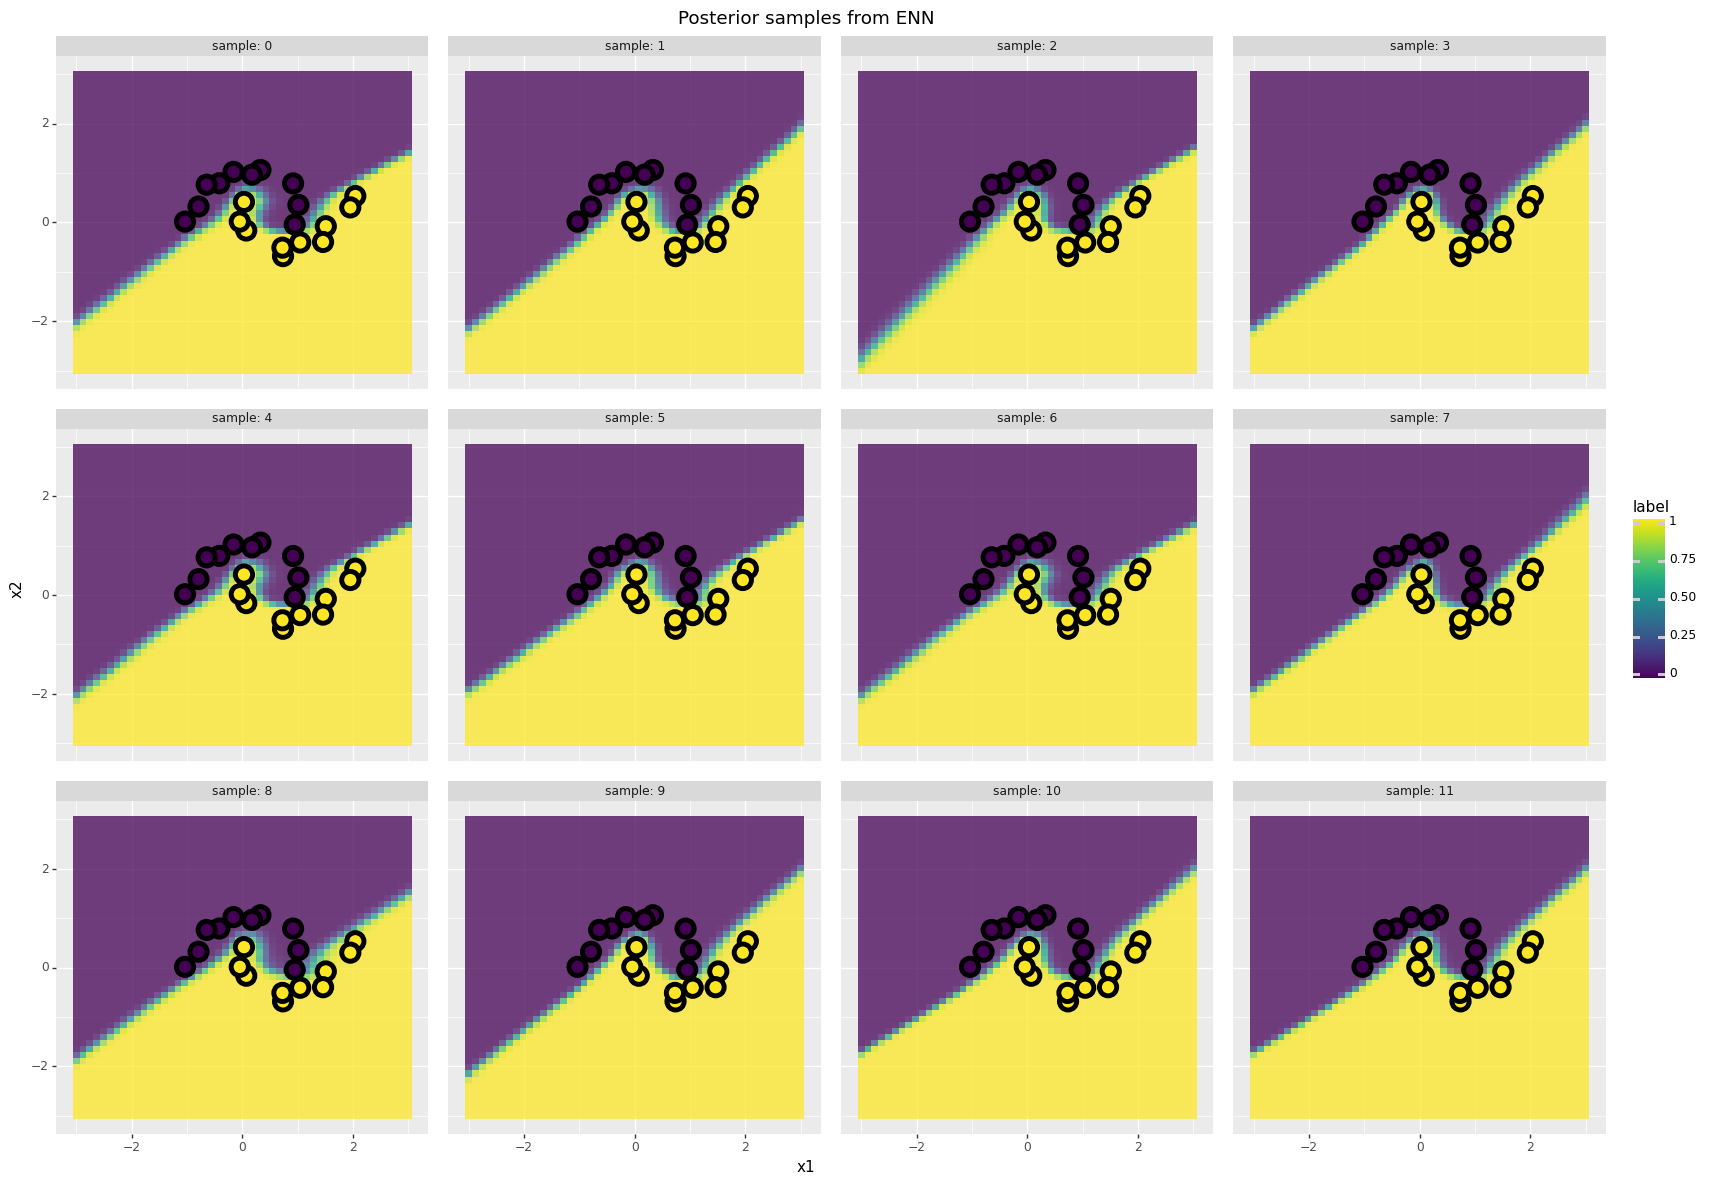

In [ ]:
#@title Plot the output
colab_plots(experiment)